# Logging Keras Models with mlflow

* Author: Johannes Maucher
* Last Update: 04.04.2022

**Goal:** In this notebook the logging of Keras Machine Learning Models with [mlflow](https://mlflow.org/docs/latest/index.html) shall be demonstrated. For this we apply a text classification task on the Reuter's newswire.

In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The following import and function call are the only additions to code required
# to automatically log metrics and parameters to MLflow.
import mlflow
import mlflow.keras

## Data Access and split in training- and test-partition

In [6]:
max_words = 1000 # only this number of most frequent words in the corpus are regarded (vocabulary-size)
batch_size = 32
epochs = 5

In [7]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)

Loading data...


In [8]:
# restore np.load for future normal usage
#np.load = np_load_old

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

8982 train sequences
2246 test sequences
46 classes


Texts are already provided as lists of indicees - each index uniquely identifies a word. The first 10 words of the first text in the trainingset are: 

In [9]:
x_train[0][:10]

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]

## Create Bag-of-Words matrix

In [10]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')

Vectorizing sequence data...
x_train shape: (8982, 1000)
x_test shape: (2246, 1000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)


## Set mlflow experiment

In [11]:
mlflow.set_experiment("Reuters Newswire Topic Classification")

2022/04/05 12:08:26 INFO mlflow.tracking.fluent: Experiment with name 'Reuters Newswire Topic Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/johannes/gitprojects/dsm-ml/mlbook/mlflowExperiments/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Reuters Newswire Topic Classification', tags={}>

In [13]:
mlflow.keras.autolog()

## Define Architecture and Training of Neural Network

In [14]:
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [15]:
print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Building model...


2022-04-05 12:09:23.833707: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               512512    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 46)                23598     
                                                                 
 activation_1 (Activation)   (None, 46)                0         
                                                                 
Total params: 536,110
Trainable params: 536,110
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

2022/04/05 12:09:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad7cc9360d7f4f7ab794a7dac675fac2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/5
253/253 [==============================] - 2s 3ms/step - loss: 1.2466 - accuracy: 0.7260 - val_loss: 0.9851 - val_accuracy: 0.7809
Epoch 2/5
253/253 [==============================] - 1s 2ms/step - loss: 0.5883 - accuracy: 0.8666 - val_loss: 0.8975 - val_accuracy: 0.7953
Epoch 3/5
253/253 [==============================] - 1s 2ms/step - loss: 0.3651 - accuracy: 0.9141 - val_loss: 0.8980 - val_accuracy: 0.7920
Epoch 4/5
253/253 [==============================] - 1s 2ms/step - loss: 0.2671 - accuracy: 0.9329 - val_loss: 0.9360 - val_accuracy: 0.7909
Epoch 5/5
253/253 [==============================] - 1s 2ms/step - loss: 0.2216 - accuracy: 0.9456 - val_loss: 0.9381 - val_accuracy: 0.7987


2022-04-05 12:09:36.057190: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/68/9tltm6l520v0stj3qjlc5v9w0000gn/T/tmpukifmtwi/model/data/model/assets


In [19]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

71/71 [==============================] - 0s 953us/step - loss: 0.9494 - accuracy: 0.7872
Test score: 0.9494234323501587
Test accuracy: 0.7871772050857544


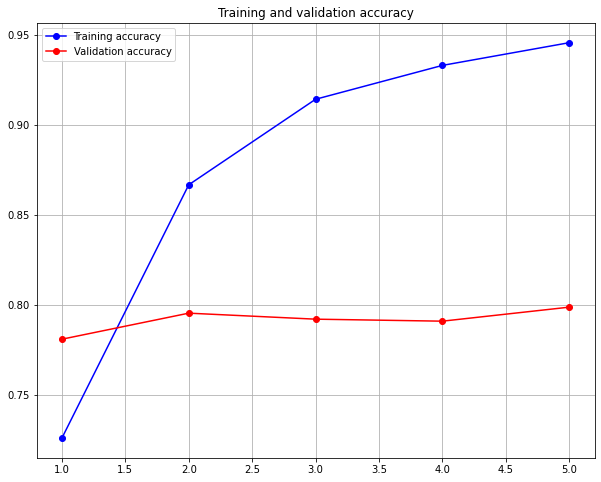

In [41]:
from matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(10,8))
plt.grid(True)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("reutersMLPclassification.png")
plt.show()

## Show logged data

### List experiments

In [31]:
mlflow.list_experiments()

[<Experiment: artifact_location='file:///Users/johannes/gitprojects/dsm-ml/mlbook/mlflowExperiments/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///Users/johannes/gitprojects/dsm-ml/mlbook/mlflowExperiments/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Reuters Newswire Topic Classification', tags={}>]

### List runs of selected experiment 

In [32]:
mlflow.list_run_infos(experiment_id="1") 

[<RunInfo: artifact_uri='file:///Users/johannes/gitprojects/dsm-ml/mlbook/mlflowExperiments/mlruns/1/ad7cc9360d7f4f7ab794a7dac675fac2/artifacts', end_time=1649153387077, experiment_id='1', lifecycle_stage='active', run_id='ad7cc9360d7f4f7ab794a7dac675fac2', run_uuid='ad7cc9360d7f4f7ab794a7dac675fac2', start_time=1649153369725, status='FINISHED', user_id='johannes'>]

### List logged data of selected run

In [33]:
mlflow.get_run(run_id="ad7cc9360d7f4f7ab794a7dac675fac2")

<Run: data=<RunData: metrics={'accuracy': 0.9455647468566895,
 'loss': 0.221638023853302,
 'val_accuracy': 0.7986651659011841,
 'val_loss': 0.9381071329116821}, params={'batch_size': '32',
 'class_weight': 'None',
 'epochs': '5',
 'epsilon': '1e-07',
 'initial_epoch': '0',
 'learning_rate': '0.001',
 'max_queue_size': '10',
 'num_layers': '4',
 'optimizer_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.1',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'keras',
 'mlflow.log-model.history': '[{"run_id": "ad7cc9360d7f4f7ab794a7dac675fac2", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-04-05 10:09:35.774806", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                             '"keras_ve

### Add additional information to an already existing run
#### Add Learning Curve

In [34]:
mlflow.start_run(run_id="ad7cc9360d7f4f7ab794a7dac675fac2")

<ActiveRun: >

In [42]:
mlflow.log_figure(fig,"reutersMLPclassification.png")